# Forecast Hornsea1 Production Notebook
Author: George Panagiotou

## Forecasting track: Hornsea1 Production

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import lightgbm as lgb
import os
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

## Load Train data:

In [2]:
train_table = pd.read_hdf('data/reference_time_06/WindTrainTable.h5', 'df')

print('Train features before removing columns:', train_table.shape)

train_times = train_table['valid_time']
train_target_variable = train_table['Wind_MWh_credit']
train_table = train_table.drop(['Wind_MWh_credit'], axis=1)
print('Train features after removing columns:', train_table.shape)

Train features before removing columns: (58898, 93)
Train features after removing columns: (58898, 92)


## Load Test data

In [3]:
test_table = pd.read_hdf('data/reference_time_06/WindTestTable.h5', 'df')

print('Test features before removing columns:', test_table.shape)

test_times = test_table['valid_time']
test_target_variable= test_table['Wind_MWh_credit']
test_table = test_table.drop(['Wind_MWh_credit'], axis=1)
print('Test features after removing columns:', test_table.shape)

Test features before removing columns: (4318, 93)
Test features after removing columns: (4318, 92)


## Transforming time into cyclic features:

In [4]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (58898, 100)
Test features after adding cyclic times and removing valid_time: (4318, 100)


## LightGBM (Tuning)
!!! DO NOT RUN !!!

In [11]:
search_spaces = {
    'learning_rate': Real(0.01, 0.5, 'uniform'),
    'max_depth': Integer(-7, 7), 
    'n_estimators': Integer(100, 300), 
    'num_leaves': Integer(20, 70)
}

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Perform Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=quantile,
        verbose=-1
    )
    # Create a custom scorer for the current quantile
    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    kf = KFold(n_splits=3)
    
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=kf,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    optimizer.fit(train_table, train_target_variable)
    best_model = optimizer.best_estimator_
    model_path = f'models/LightGB/LGBR_Wind_BEST_q{int(quantile * 100)}.txt'
    best_model.booster_.save_model(model_path)
    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and print CV error for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")

Running Bayesian optimization search for the 10.0% quantile.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters for 10.0% quantile: OrderedDict([('learning_rate', 0.08562132026865649), ('max_depth', -3), ('n_est

## Train set:

We are going to make predictions of the training set. Then, we will use the predictions as the new training set for the ensemble method that is going to combine both solar and wind production and predict the hybrid production of both. 

In [6]:
quantile_predictions = {}
quantile_predictions['Wind_MWh_credit'] = train_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/LightGB/LGBR_Wind_BEST_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(train_table)

# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them 
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)


# Training loss
print('Training Loss (Quantile):', pinball_score(quantile_predictions_df,target_col='Wind_MWh_credit'))

# Save the predictions
quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/LightGB/Wind_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Training Loss (Quantile): 18.43888427232773


## Test set

We will use the predictions as the new test set for the ensemble method that is going to combine both solar and wind production and predict the hybrid production of both. 

In [7]:
quantile_predictions = {}
quantile_predictions['Wind_MWh_credit'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/LightGB/LGBR_Wind_BEST_q{qu}.txt'
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(test_table)

# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them 
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

# Test loss
print('Test Loss(Quantile):',pinball_score(quantile_predictions_df,target_col='Wind_MWh_credit'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/LightGB/Wind_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Test Loss(Quantile): 17.819166017323557


## Plot Quantiles (Probabilistic Forecasting) : 

In [9]:
save_path = "plots/LightGB/Wind_LGBR.html"
graph_title = "Hornsea1: Forecast (LightGBRegressor)"
quantile_predictions_df['time'] = train_times 
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'Wind_MWh_credit', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

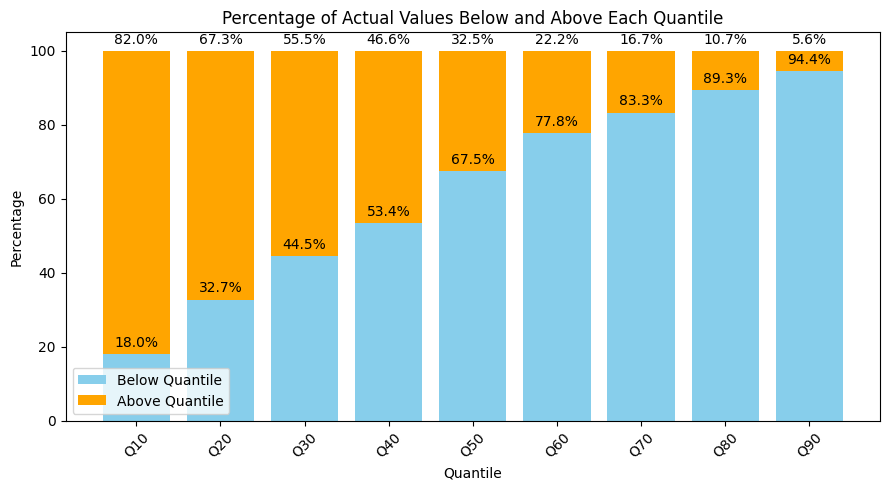

In [10]:
quantile_stats(quantile_predictions_df,'Wind_MWh_credit')

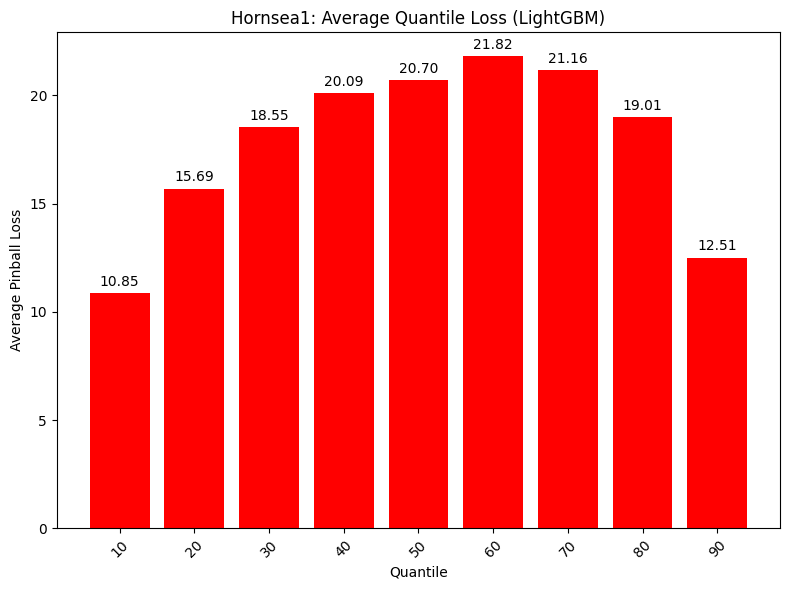

In [12]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'Wind_MWh_credit', "Hornsea1: Average Quantile Loss (LightGBM)")